## Alpha Comae

Alpha Comae (ACom) is a visible double star with an orbit which is almost perpendicular to the sky plane. The stars are dancing in an apparent straight line around each other. The orbital plane could be so perpendicular that the stars will eclipse. This has not been observed yet. Partly due to a lack of precision in the determination of the orbital elements. 

Positional data for the double star ACom were taken from the SIDONIe database (sidonie.oca.eu). The distance and angle data are transformed into (x,y) positions. 

As both stars are very similar spectral type (F5) and in brightness it is easy to confuse the components. From simple inspection of the data it is immediately obvious that this confusion has crept into the data. An important part in the analysis of the orbital elements is the proper identification of the components.

We employ a two stage strategy. First we identify the proper angles, visually, from continuity of the data. After a fit of the orbital elements, we determine the distances of the data to the model and also of the "mirror-data" where all (x,y) are changed into (-x,-y). The latter points represent the misidentifications. 
If an mirror-data point is closer to the model than the pertaining data point, we conclude that we have a misidentification, and replace the data point with the mirror-data point.

With the new dataset we run the fitting process again.





Author: Do Kester


We need to import some classes

In [1]:
import numpy as numpy
import math

from astropy.io import ascii
from BayesicFitting import StellarOrbitModel
from BayesicFitting import MultipleOutputProblem
from BayesicFitting import PolynomialModel
from BayesicFitting import CircularUniformPrior

from BayesicFitting import NestedSampler
from BayesicFitting import formatter as fmt
from BayesicFitting import plotFit
from BayesicFitting import Tools
import matplotlib.pyplot as plt



In [2]:
#%matplotlib osx

Read the data

In [3]:
tbl = ascii.read( "data/alfcom.dat", include_names=['Date', 'Angle', 
                                            'Separ', 'Nights', 'Precis'] )
# The table lists:
#   fractional years 
#   angle in degree 
#   separation in arcsec
#   number of nights the star is observed
#   precision in number of decimals in the separation (2 or 3)
yr = tbl['Date'].data
phi = tbl['Angle'].data
dis = tbl['Separ'].data
nts = tbl['Nights'].data
prc = tbl['Precis'].data

phi = numpy.where( phi > 300, phi - 360, phi )

A bit of data massaging. 

In [4]:
# A bit of trial and error to identify the data points
per = 25.8696
yr9 = yr - 9.5
orbit = yr9 % per
ql = numpy.where( orbit < 13 )
qu = numpy.where( orbit >= 13 )

## indentification is in chuncks.
pql = phi[ql]
phi[ql] = numpy.where( pql > 100, pql - 180, pql )
pqu = phi[qu]
phi[qu] = numpy.where( pqu < 100, pqu + 180, pqu )

ml = numpy.median( phi[ql] )
mu = numpy.median( phi[qu] )
#print( ml, mu )

th = phi * math.pi / 180

## Do we need a correction for leap years. They are 0.3% longer
yr -= 1900
xpos = dis * numpy.cos( th )
ypos = dis * numpy.sin( th )

# Make weights proportional to the number of nights observed and 
# divide by 4 if the precision is given in 2 decimals in stead of 3 
wgt = numpy.where( prc == 3, nts, nts / 4 )

## Second stage. Comment next lines out for the first stage.
## q lists the data points that were misidentified in the 1st stage.
q = numpy.array( [ 20,  60,  90, 133, 134, 290] )
xpos[q] *= -1
ypos[q] *= -1

# Combine xpos and ypos into a 2-d array: pos
pos = numpy.append( xpos, ypos ).reshape( 2, -1 ).transpose()

We define a stellar orbit model. It has 7 parameters: eccentricity, semimajor axis, period, periastron phase, inclination of the orbit, longitude of ascending node and phase of the ascending node.

All 4 phase parameters get a CircularUniformPrior 0 to 2 pi.


In [5]:
twopi = 2 * math.pi
mdl = StellarOrbitModel()
## eccen, semimaj, period, phase, inclin, node phase, node pos
lolim = [0.0, 0.0, 20.0]
hilim = [0.9, 1.0, 30.0]
mdl.setLimits( lowLimits=lolim, highLimits=hilim )
for k in range( 3, 7 ):
    mdl.setPrior( k, prior=CircularUniformPrior(), limits=[0,twopi] )
#Tools.printclass( mdl )

Define a MultipleOutputProblem which reorganises the multiple outputs: (x,y) into a 1-d array that can be handled by the NestedSampler.

Define NestedSampler with extended ensemble for better precision.

In [6]:
problem = MultipleOutputProblem( model=mdl, xdata=yr, ydata=pos, 
                                weights=wgt )
# define NestedSampler
ns = NestedSampler( problem=problem, seed=1308 )
ns.ensemble = 500
# set limits on the noise scale of the distribution
ns.distribution.setLimits( [0.01,100] )

# run NestedSampler
evi = ns.sample( )

Fit all parameters of
  StellarOrbit 
Using a Gauss error distribution with with unknown scale
Moving the walkers with   GalileanEngine  ChordEngine
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>
Iteration   logZ        H     LowL     npar    parameters
   41485   1120.0     41.5   1165.0      8  [    0.516    0.680   25.899    2.809    4.712 ...]
Engines              success     reject     failed       best      calls
GalileanEngine        281635      96302     107155         74      41485
ChordEngine           290692     497687          0         33      41485
Calls to LogL        1273471   to dLogL      96302
Sam

Print parameters and standard deviations, first as they were derived and then in an alternative form with angles in "degrees" and the periastron in years.

In [7]:
sl = ns.samples
par = sl.parameters
std = sl.stdevs
pard = par.copy()
pard[3:] *= 180 / math.pi
pard[3] *= pard[2] / 360
pard[3] += 1900
stda = std.copy()
stda[3:] *= 180 / math.pi
stda[3] *= pard[2] / 360
names = mdl.parNames
print( "         ", end="" )
for nm in names :
    print( " %8.8s"% nm, end="" )
print()
print( "Pars   ", fmt( par, max=None ) )
print( "Stdev  ", fmt( std, max=None ) )
print( "Par_alt", fmt( pard, max=None ) )
print( "Std_alt", fmt( stda, max=None ) )
print( "Scale     ", fmt( sl.scale ), "+-", fmt( sl.stdevScale ) )
print( "Evidence  ", fmt( evi ) )
print( "periastron times" )
for k in range( -3, 6 ) :
    print( fmt( pard[3] + k * par[2] ), end='' )
print()



          eccentri semimajo   period periastr inclinat ascendin ascendin
Pars    [    0.519    0.681   25.898    2.809    4.712    0.213    1.742]
Stdev   [    0.016    0.008    0.021    0.012    0.004    0.005    0.008]
Par_alt [    0.519    0.681   25.898 1911.579  269.967   12.203   99.818]
Std_alt [    0.016    0.008    0.021    0.050    0.231    0.285    0.460]
Scale          0.058 +-     0.001
Evidence     486.405
periastron times
 1833.884 1859.782 1885.680 1911.579 1937.477 1963.375 1989.273 2015.172 2041.070


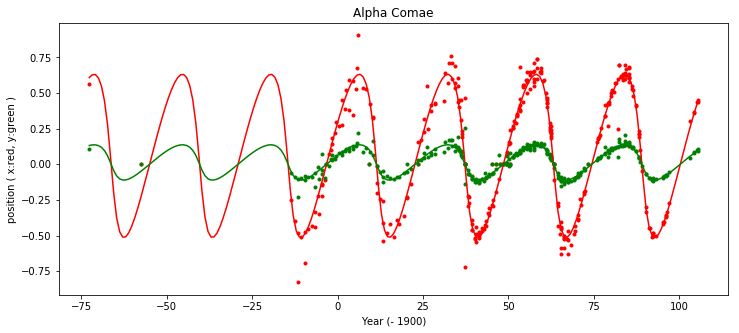

In [8]:
plt.figure( "results", figsize=(12,5) )
plt.plot( yr, xpos, 'r.' )
plt.plot( yr, ypos, 'g.' )
xx = numpy.linspace( yr[0], yr[-1], 201, dtype=float )
yy = mdl.result( xx, par )
plt.plot( xx, yy[:,0], 'r-' )
plt.plot( xx, yy[:,1], 'g-' )

plt.xlabel( "Year (- 1900)")
plt.ylabel( "position ( x:red, y:green )")
plt.title( "Alpha Comae" )
plt.show()

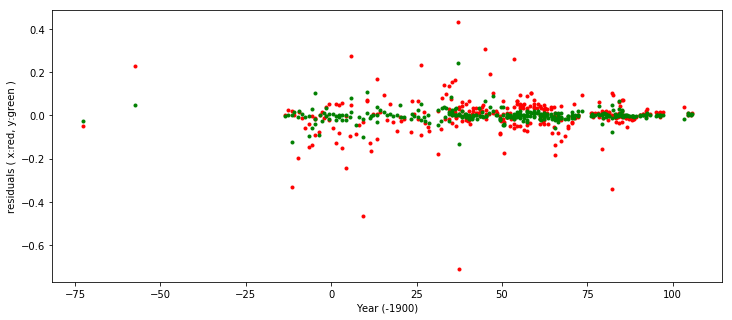

In [9]:
plt.figure( "Residuals", figsize=(12,5) )
yf = mdl.result( yr, par )
xres = xpos - yf[:,0]
yres = ypos - yf[:,1]
plt.plot( yr, xres, 'r.' )
plt.plot( yr, yres, 'g.' )
plt.xlabel( "Year (-1900)")
plt.ylabel( "residuals ( x:red, y:green )")
plt.show()

Check if there are (still) mirror-data residuals which are smaller than the proper residuals. 

In the 1st stage there were 6 of those points.

In the 2nd stage there are none left.

In [10]:
resp = numpy.sum( numpy.square( +pos - yf ), 1 )
resm = numpy.sum( numpy.square( -pos - yf ), 1 )
q = numpy.where( resp > resm )
print( q )
for k in q[0] :
    print( fmt(k),fmt(yr[k]), fmt(pos[k,:]),fmt(resp[k]), fmt(resm[k]) )


(array([], dtype=int64),)


We have a consistent solution i.e. one where all sky angles are consistent with the model derived.

What about eclipsing in 2014/5. 
Using the optimal average solution for the parameters, it seems that the closest approach is on 22 dec 2014. It is also nicely within the 0.7 mas zone that would entail an eclipse.

However ...

358 23 25 dec


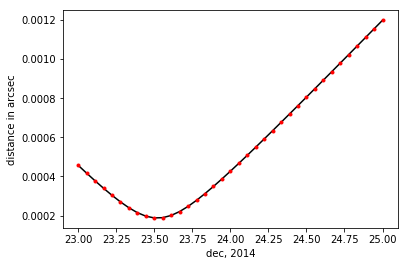

time of closest   2014.979


In [11]:
mnts = [31,28,31,30,31,30,31,31,30,31,30,31]
mnms = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

ys = numpy.linspace( 114., 116., 731, dtype=float )   # 2 years in days
xs = mdl.result( ys, par )
rs = numpy.sqrt( numpy.square( xs[:,0] ) + numpy.square( xs[:,1] ) )
krs = numpy.argmin( rs )

k0 = math.floor( krs - 1 )
k1 = math.ceil( krs + 1 )

npt = 37
y0 = 2014.0 + k0/365         # 21 dec 2014 (1 jan starts at 0)
y1 = 2014.0 + k1/365         # 24 dec 2014
for j in range( 12 ):
    mname = mnms[j]
    if k0 - mnts[j] < 0 :
        break
    k0 -= mnts[j]
    k1 -= mnts[j]

print( krs, k0, k1, mname )

ys = numpy.linspace( y0-1900, y1-1900, npt )
xs = mdl.result( ys, par )
rs = numpy.sqrt( numpy.square( xs[:,0] ) + numpy.square( xs[:,1] ) )
march = numpy.linspace( k0, k1, npt )
plt.plot( march, rs, 'k-' )
plt.plot( march, rs, 'r.' )
plt.xlabel( mname + ", 2014" )
plt.ylabel( "distance in arcsec" )
plt.show()
mn = numpy.argmin( rs )
ysm = ys[mn] + 1900
print( "time of closest ", fmt(ysm) )
ym = int( ysm )
day = 365.0 * ( ysm - ym )
#print( fmt( ym ), fmt( day ), fmt( 1000 * rs[mn] ) )

However we should use the posterior for drawing such conclusions. We have the posterior in the form of samples with an associated weight.
For each sample we run the model and determine the closest passage to the origin (where ACom A) sits. For the closest approach we get the time, the distance and the duration the orbit stays closer than 0.7 mas.

In [12]:
ys = numpy.linspace( 114., 116., 731, dtype=float )   # 2 years in days
ym = numpy.linspace( -2, 2, 97 ) / 365.            # 2 days on each side in hours
histy = numpy.zeros( 301 )
histp = numpy.zeros( 301 )
histr = numpy.zeros( 201 )
histw = numpy.zeros( 201 )
mnts = [31,28,31,30,31,30,31,31,30,31,30,31]
mnms = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
sw = sx = sx2 = sy = sy2 = perc = 0
for s in sl :
    if s.logW < -40.0 : continue      # they do not contribute
    wgt = s.weight
    
    xs = mdl.result( ys, s.parameters )
    rs = numpy.sqrt( numpy.square( xs[:,0] ) + numpy.square( xs[:,1] ) )

    krs = numpy.argmin( rs )
    if krs == 0 or krs == 731 : continue      # no minimum found
    
    sw += wgt
    yms = ys[krs] + ym
    xms = mdl.result( yms, s.parameters )
    rms = numpy.sqrt( numpy.square( xms[:,0] ) + numpy.square( xms[:,1] ) )
    km = numpy.argmin( rms )
    yclose = yms[km]
    yday = ( yclose - int( yclose ) ) * 365
    for n,month in zip( mnts, mnms ) :
        if yday < n : break
        yday -= n
    yhour = ( yday - int( yday ) ) * 24
    kh = int( ( ( yclose - 114 ) * 365 - 200 ) * 1 )
    if kh < 0 : kh = 0
    if kh > 300 : kh = 300
    histy[kh] += wgt
    xclose = rms[km]
    kr = int( xclose * 40000 )
    if kr > 200 : kr = 200
    histr[kr] += wgt
    q = numpy.where( rms < 0.0007 )[0]
    lq = 2 * len( q )
    if lq > 200 : lq = 200
    if lq > 1 : histw[lq:lq+2] += wgt
    if xclose < 0.0007 :
        perc += wgt
        histp[kh] += wgt
    #print( "%4d-%s-%2d:%2d"%( int(ys[krs]+1900), month, 
    #        int(yday), int(yhour) ), fmt(1000*xclose), lq )
    sy += wgt * yclose
    sy2 += wgt * yclose * yclose
    sx += wgt * xclose
    sx2 += wgt * xclose * xclose

sx /= sw
sy /= sw 
perc /= sw
perc *= 100
sx2 = math.sqrt( sx2/sw - sx * sx )
sy2 = math.sqrt( sy2/sw - sy * sy )
sy2 *= 365
sy += 1900
print( "sumwgts  ", fmt( sw ) )
print( "distance ", fmt(1000*sx), "+-", fmt(1000*sx2), "(mas)" )
print( "eclipse? ", fmt(perc), "%" )
print( "time     ", fmt(sy), "+-", fmt(sy2), "(days)" )


sumwgts       1.000
distance      1.037 +-     0.856 (mas)
eclipse?     43.280 %
time       2014.979 +-    22.075 (days)


Plot 2 histograms. 
The first one with the times of closest approach: all in black; the eclipsing ones in red.
The second one shows the distances on the bottom scale. Again all in black and the eclipsing ones in red. In the same plot in green, is the duration of the eclipse (if so) on the top scale in hours. 

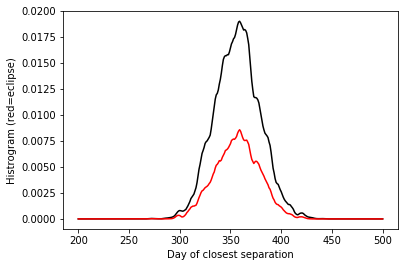

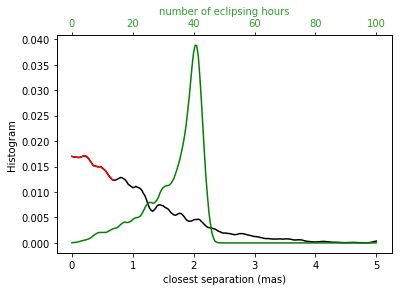

In [13]:
## Smooth the histograms somewhat. 
## Even now the wiggles are probably unreal. 
nb = 5
box = numpy.ones( nb, dtype=float ) / nb
ons = numpy.ones_like( histr )
for k in range( 2 ) :
    histy = numpy.convolve( histy, box, mode="same" )
    histp = numpy.convolve( histp, box, mode="same" )
    histr = numpy.convolve( histr, box, mode="same" )
    histw = numpy.convolve( histw, box, mode="same" )
    ons = numpy.convolve( ons, box, mode="same" )
histr /= ons
histw /= ons

hyx = numpy.linspace( 200, 500, 301 )
plt.plot( hyx, histy, 'k-' )
plt.plot( hyx, histp, 'r-' )
plt.xlabel( "Day of closest separation" )
plt.ylabel( "Histrogram (red=eclipse)")
plt.show()
hxx = numpy.linspace( 0, 5, 201 )

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('closest separation (mas)')
ax1.set_ylabel('Histogram' )
ax1.plot( hxx, histr, 'k-' )
ax1.plot( hxx[:28], histr[:28], 'r-' )

ax2 = ax1.twiny()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_xlabel('number of eclipsing hours', color=color)  # we already handled the x-label with ax1
hxw = numpy.linspace( 0, 100, 201 )
ax2.plot( hxw, histw, 'g-' )
ax2.tick_params(axis='x', labelcolor=color)


plt.show()

We can do the same for the possible eclipses in 2026 and 2040. 
It suggests that we get eclipses at both times, but full posterior analysis will probably temper our hopes. Moreover it is further in the future where projections deteriorate. 


86 25 28 mar


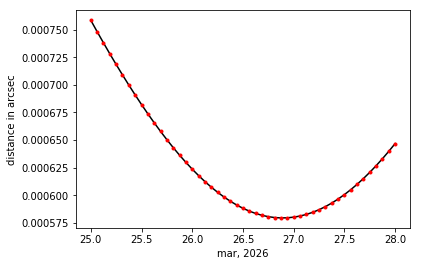

2026.2352739726027
     2026    85.875     0.579


In [14]:
ys = numpy.linspace( 126., 127., 366, dtype=float )   # 1 years in days
xs = mdl.result( ys, par )
rs = numpy.sqrt( numpy.square( xs[:,0] ) + numpy.square( xs[:,1] ) )
krs = numpy.argmin( rs )

k0 = math.floor( krs - 2 )
k1 = math.ceil( krs + 1 )

npt = 49
y0 = 2026.0 + k0/365
y1 = 2026.0 + k1/365
for j in range( 12 ):
    mname = mnms[j]
    if k0 - mnts[j] < 0 :
        break
    k0 -= mnts[j]
    k1 -= mnts[j]

print( krs, k0, k1, mname )

ys = numpy.linspace( y0-1900, y1-1900, npt )
xs = mdl.result( ys, par )
rs = numpy.sqrt( numpy.square( xs[:,0] ) + numpy.square( xs[:,1] ) )
march = numpy.linspace( k0, k1, npt )
plt.plot( march, rs, 'k-' )
plt.plot( march, rs, 'r.' )
plt.xlabel( mname + ", 2026" )
plt.ylabel( "distance in arcsec" )
plt.show()
mn = numpy.argmin( rs )
ysm = ys[mn] + 1900
print( ysm )
ym = int( ysm )
day = 365.0 * ( ysm - ym )
print( fmt( ym ), fmt( day ), fmt( 1000 * rs[mn] ) )

321 319 322
321 14 17 nov


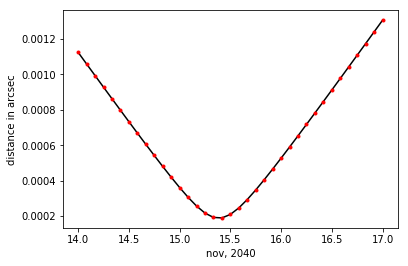

2040.8778538812785


In [15]:
mnts[1] = 29       ## 2040 is leap year
ys = numpy.linspace( 140., 141., 367, dtype=float )   # 1 leap years in days
xs = mdl.result( ys, par )
rs = numpy.sqrt( numpy.square( xs[:,0] ) + numpy.square( xs[:,1] ) )
krs = numpy.argmin( rs )

k0 = math.floor( krs - 2 )
k1 = math.ceil( krs + 1 )
print( krs, k0, k1 )
npt = 37
y0 = 2040.0 + k0/365
y1 = 2040.0 + k1/365
for j in range( 12 ):
    mname = mnms[j]
    if k0 - mnts[j] < 0 :
        break
    k0 -= mnts[j]
    k1 -= mnts[j]

print( krs, k0, k1, mname )

ys = numpy.linspace( y0-1900, y1-1900, npt )
xs = mdl.result( ys, par )
rs = numpy.sqrt( numpy.square( xs[:,0] ) + numpy.square( xs[:,1] ) )
nov = numpy.linspace( k0, k1, npt )
#plt.plot( ys, rs, 'k.' )
plt.plot( nov, rs, 'k-' )
plt.plot( nov, rs, 'r.' )
plt.xlabel( mname + ", 2040" )
plt.ylabel( "distance in arcsec" )
plt.show()
mn = numpy.argmin( rs )
ysm = ys[mn] + 1900
print( ysm )
ym = int( ysm )
day = 366.0 * ( ysm - ym )
#print( fmt( ym ), fmt( day ), fmt( 1000 * rs[mn] ) )
